# Загрузка PLAID

In [6]:
%matplotlib inline

import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime

import matplotlib

import warnings

In [7]:
# functions to read data and meta data
def read_data_given_id(path,ids,progress=True,last_offset=0):
    '''read data given a list of ids and CSV paths'''
    start = datetime.now()
    n = len(ids)
    if n == 0:
        return {}
    else:
        data = {}
        for (i,ist_id) in enumerate(ids, start=1):
            if progress and np.mod(i,np.ceil(n/10))==0:
                print('%d/%d (%2.0f%s) have been read...\t time consumed: %ds'\
                      %(i,n,i/n*100,'%',(datetime.now()-start).seconds))
            if last_offset==0:
                data[ist_id] = np.genfromtxt(path+str(ist_id)+'.csv',delimiter=',',\
                                         names='current,voltage',dtype=(float,float))
            else:
                p=subprocess.Popen(['tail','-'+str(int(last_offset)),path+str(ist_id)+'.csv'],\
                                   stdout=subprocess.PIPE)
                data[ist_id] = np.genfromtxt(p.stdout,delimiter=',',names='current,voltage',dtype=(float,float))
        print('%d/%d (%2.0f%s) have been read(Done!) \t time consumed: %ds'\
            %(n,n,100,'%',(datetime.now()-start).seconds)) 
        return data

In [8]:
import json

Data_path = '../PLAID_s'
csv_path = Data_path + '/submetered/submetered_new/'

with open(Data_path + '/metadata_submetered.json') as data_file:    
     meta1 = json.load(data_file)

In [9]:
IDs_for_read_data = list(meta1.keys())
Types = [meta1[key]['appliance']['type'] for key in IDs_for_read_data]
Unq_type = list(set(Types))
Unq_type.sort()
Locs = [meta1[key]['header']['collection_time'] + '_' + meta1[key]['location'] for key in meta1.keys()]
Unq_loc = list(set(Locs))
Unq_loc.sort()
Original_Unq_type = Unq_type

In [10]:
# read data
# estimated time cost:  ~ 1 mins
npts = 10000
Data = read_data_given_id(csv_path,IDs_for_read_data,progress=True, last_offset=npts)

188/1876 (10%) have been read...	 time consumed: 4s
376/1876 (20%) have been read...	 time consumed: 9s
564/1876 (30%) have been read...	 time consumed: 13s
752/1876 (40%) have been read...	 time consumed: 18s
940/1876 (50%) have been read...	 time consumed: 23s
1128/1876 (60%) have been read...	 time consumed: 28s
1316/1876 (70%) have been read...	 time consumed: 33s
1504/1876 (80%) have been read...	 time consumed: 38s
1692/1876 (90%) have been read...	 time consumed: 44s
1876/1876 (100%) have been read(Done!) 	 time consumed: 49s


In [11]:
Data['1']['current'].shape

(10000,)

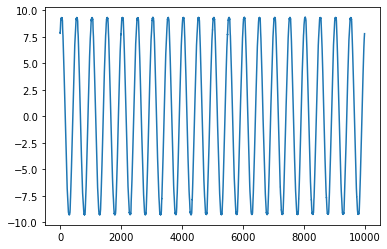

In [12]:
plt.plot(Data['769']['current'])

In [13]:
fs = 30000
f0 = 60
NS = fs//f0 # number of samples per period
NP = npts//NS # number of periods for npts

# calculate the representative one period of steady state 
# (mean of the aggregated signals over one cycle)
n = len(Data)
rep_I = np.empty([n,NS])
rep_V = np.empty([n,NS])
for i in range(n):
    tempI = np.sum(np.reshape(Data[str(i+1)]['current'],[NP,NS]),0)/NP
    tempV = np.sum(np.reshape(Data[str(i+1)]['voltage'],[NP,NS]),0)/NP
    # align current to make all samples start from 0 and goes up
    ix = np.argsort(np.abs(tempI))
    j = 0
    while True:
        if ix[j]<499 and tempI[ix[j]+1]>tempI[ix[j]]:
            real_ix = ix[j]
            break
        else:
            j += 1
    rep_I[i,] = np.hstack([tempI[real_ix:],tempI[:real_ix]])
    rep_V[i,] = np.hstack([tempV[real_ix:],tempV[:real_ix]])

# CWT

In [14]:
import pywt

In [15]:
def make_recurcisve_wavelet_plot(data, waveletname, iters):
    fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    for ii in range(iters):
        (data, coeff_d) = pywt.dwt(data, waveletname)
        if ii == iters - 1:
            axarr[0].plot(data, 'r')
            axarr[1].plot(coeff_d, 'g')
            axarr[0].set_ylabel("{}".format(ii + 1), fontsize=14, rotation=90)
            axarr[0].set_yticklabels([])
            axarr[1].set_yticklabels([])
    plt.tight_layout()
    plt.show()

In [16]:
def make_recurcisve_wavelet_transform(data, waveletname, iters):
    for ii in range(iters):
        (data, coeff_d) = pywt.dwt(data, waveletname)
        if ii == iters - 1:
            return data, coeff_d

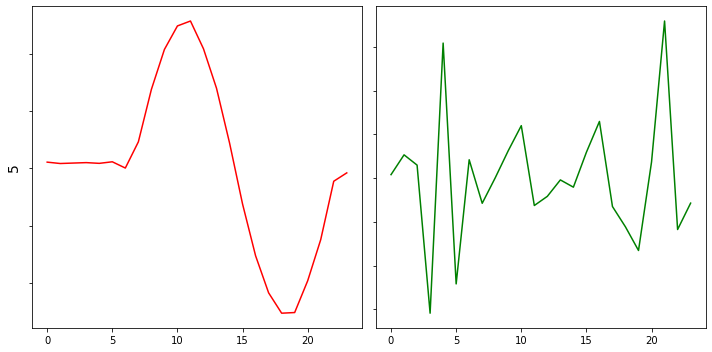

In [17]:
make_recurcisve_wavelet_plot(rep_I[1769], 'db5', 5)

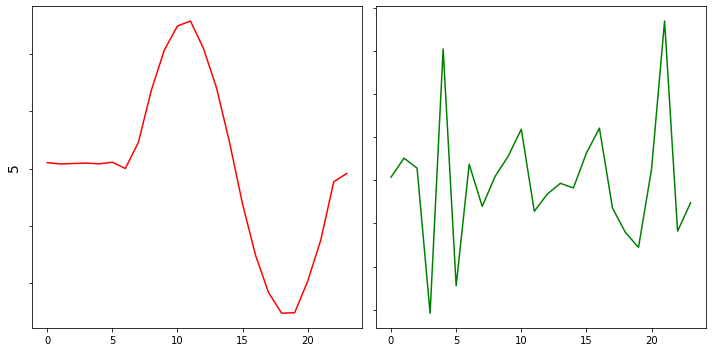

In [18]:
make_recurcisve_wavelet_plot(rep_I[1770], 'db5', 5)

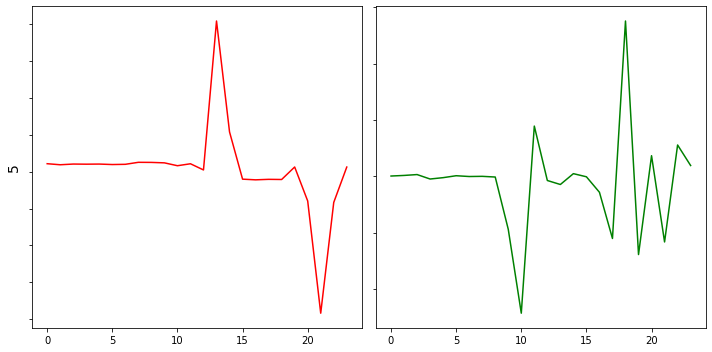

In [19]:
make_recurcisve_wavelet_plot(rep_I[1000], 'db5', 5)

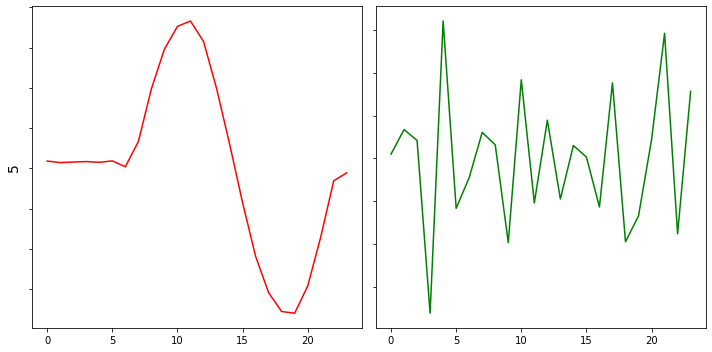

In [20]:
make_recurcisve_wavelet_plot(rep_I[235], 'db5', 5)

In [21]:
def center(X,w):
    minX = np.amin(X)
    maxX = np.amax(X)
    dist = max(abs(minX),maxX)
    X[X<-dist] = -dist
    X[X>dist] = dist
    d = (maxX-minX)/w
    return (X,d)
    
def get_img_from_coef(coefs, steps, width,hard_threshold=False,para=.5):
    d = coefs.shape[0]
    # doing interploation if number of points is less than width*2
    if d < 2 * width:
        newsteps = np.hstack([coefs, coefs[0]])
        newcoefs = np.hstack([steps, steps[0]])
        oldt = np.linspace(0, d, d + 1)
        newt = np.linspace(0, d, 2*width)
        steps = np.interp(newt, oldt, newsteps)
        coefs = np.interp(newt, oldt, newcoefs)
    # center the current and coefsoltage, get the size resolution of mesh gicoefsen width    
    (steps, d_c)  = center(steps, width)
    (coefs, d_coefs)  = center(coefs, width)
    
    #  find the index where the coefssteps goes through in current-coefsoltage axis
    ind_c = np.floor((steps - np.amin(steps)) / d_c).astype(int)
    ind_coefs = np.floor((coefs - np.amin(coefs)) / d_coefs).astype(int)
    ind_c[ind_c==width] = width - 1
    ind_coefs[ind_coefs==width] = width - 1
    
    stepsmg = np.zeros((width,width))
    
    for i in range(len(steps)):
        stepsmg[ind_c[i],width-ind_coefs[i]-1] += 1
    
    if hard_threshold:
        stepsmg[stepsmg<para] = 0
        stepsmg[stepsmg!=0] = 1
        return stepsmg
    else:
        return (stepsmg/np.max(stepsmg))**para

In [22]:
n = len(Data)
width = 16

Imgs = np.zeros((n,width,width), dtype=np.float64)
for i in range(n):
    data_I, coef_I = make_recurcisve_wavelet_transform(rep_I[i], 'db5', 5)
    Imgs[i,:,:] = get_img_from_coef(coef_I, np.linspace(0, len(coef_I), len(coef_I)), width,True,1)
BinaryF=np.reshape(Imgs, (n, width * width))

In [23]:
type_Ids = {}
loc_Ids = {}
n = len(Data)
type_label = np.zeros(n,dtype='int')
loc_label = np.zeros(n,dtype='int')
for (ii,t) in enumerate(Unq_type):
    type_Ids[t] = [i-1 for i,j in enumerate(Types,start=1) if j == t]
    type_label[type_Ids[t]] = ii+1
for (ii,t) in enumerate(Unq_loc):
    loc_Ids[t] = [i-1 for i,j in enumerate(Locs,start=1) if j == t]
    loc_label[loc_Ids[t]] = ii+1
print('number of different types: %d'% len(Unq_type))
print('number of different households: %d'% len(Unq_loc))

number of different types: 16
number of different households: 65


<ipython-input-24-9f146c8c15b2>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.ceil(n / 10), 15, count)


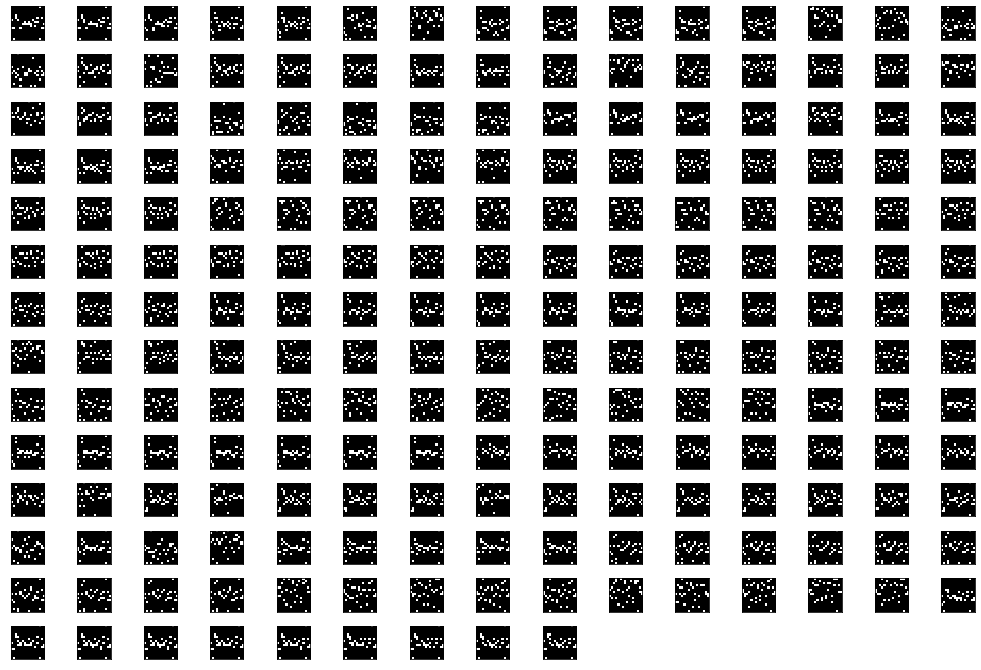

In [24]:
# visualization of all imgaes from certain type in Imgs
type_id = 1
n = sum(type_label==type_id)
fig = plt.figure(figsize=(14,np.ceil(n/15)))
count = 1
for i in np.where(type_label==type_id)[0]:
    plt.subplot(np.ceil(n / 10), 15, count)
    plt.imshow(Imgs[i,:,:],cmap = cm.Greys_r,interpolation='None')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    count += 1
fig.tight_layout()
plt.show()

# CNN

In [25]:
from sklearn.model_selection import train_test_split


X_train_cwt, X_test_cwt, y_train_cwt, y_test_cwt = train_test_split(BinaryF, type_label, test_size=0.1, random_state=42)

In [26]:
from collections import defaultdict, Counter
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.models import Sequential
from keras.layers import Dropout

from keras.callbacks import History 

history_cwt = History()
img_x_cwt = 16
img_y_cwt = 16
img_z_cwt = 1

num_classes = 17

x_train_cwt = X_train_cwt.reshape(X_train_cwt.shape[0], img_x_cwt, img_y_cwt, img_z_cwt)
x_test_cwt = X_test_cwt.reshape(X_test_cwt.shape[0], img_x_cwt, img_y_cwt, img_z_cwt)
y_train_cwt = keras.utils.to_categorical(y_train_cwt, num_classes)
y_test_cwt = keras.utils.to_categorical(y_test_cwt, num_classes)

In [27]:
input_sh_cwt = (img_x_cwt, img_y_cwt, img_z_cwt)
epochs = 50
batch_size = 200

model_cwt = Sequential()
model_cwt.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), input_shape=input_sh_cwt))
model_cwt.add(AveragePooling2D(pool_size=(3, 3), strides=(1, 1)))
model_cwt.add(Conv2D(64, kernel_size=(2, 2), strides=(1, 1)))
model_cwt.add(AveragePooling2D(pool_size=(2, 2)))
model_cwt.add(Flatten())
model_cwt.add(Dense(1000, activation='relu'))
model_cwt.add(Dropout(0.2, input_shape=(1,)))
model_cwt.add(Dense(num_classes, activation='softmax'))
                     
model_cwt.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

model_cwt.fit(x_train_cwt, y_train_cwt, batch_size=batch_size, 
          epochs=epochs, verbose=1, 
          validation_data=(x_test_cwt, y_test_cwt), 
          callbacks=[history_cwt])

train_score = model_cwt.evaluate(x_train_cwt, y_train_cwt, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model_cwt.evaluate(x_test_cwt, y_test_cwt, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Epoch 1/50
9/9 [==============================] - 1s 78ms/step - loss: 2.5856 - accuracy: 0.2179 - val_loss: 2.2017 - val_accuracy: 0.3085
Epoch 2/50
9/9 [==============================] - 0s 49ms/step - loss: 2.1262 - accuracy: 0.3191 - val_loss: 1.9239 - val_accuracy: 0.3989
Epoch 3/50
9/9 [==============================] - 0s 49ms/step - loss: 1.7526 - accuracy: 0.4382 - val_loss: 1.6774 - val_accuracy: 0.3883
Epoch 4/50
9/9 [==============================] - 0s 49ms/step - loss: 1.5037 - accuracy: 0.5037 - val_loss: 1.4576 - val_accuracy: 0.5000
Epoch 5/50
9/9 [==============================] - 0s 49ms/step - loss: 1.2673 - accuracy: 0.5849 - val_loss: 1.2510 - val_accuracy: 0.5691
Epoch 6/50
9/9 [==============================] - 0s 49ms/step - loss: 1.1532 - accuracy: 0.6265 - val_loss: 1.1081 - val_accuracy: 0.6596
Epoch 7/50
9/9 [==============================] - 0s 48ms/step - loss: 1.0131 - accuracy: 0.6851 - val_loss: 1.0714 - val_accuracy: 0.6436
Epoch 8/50
9/9 [===========

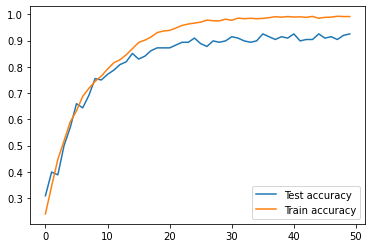

In [28]:
plt.plot(history_cwt.epoch, np.array(history_cwt.history['val_accuracy']),
           label = 'Test accuracy')
plt.plot(history_cwt.epoch, np.array(history_cwt.history['accuracy']),
           label = 'Train accuracy')
plt.legend()
plt.show()

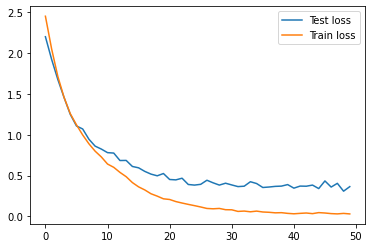

In [29]:
plt.plot(history_cwt.epoch, np.array(history_cwt.history['val_loss']),
           label = 'Test loss')
plt.plot(history_cwt.epoch, np.array(history_cwt.history['loss']),
           label = 'Train loss')
plt.legend()
plt.show()

In [30]:
wavelet_db5 = pywt.Wavelet('sym2')
pywt.dwt_max_level(data_len=len(rep_I[0]), filter_len=wavelet_db5.dec_len)

7

# CWT Families

In [31]:
def make_BinaryF(wavelet_name, levels_num, rep):
    n = len(Data)
    width = 16

    Imgs = np.zeros((n,width,width), dtype=np.float64)
    for i in range(n):
        data, coef = make_recurcisve_wavelet_transform(rep[i], wavelet_name, levels_num)
        Imgs[i,:,:] = get_img_from_coef(coef, np.linspace(0, len(coef), len(coef)), width, True, 1)
    BinaryF = np.reshape(Imgs, (n, width * width))
    return BinaryF

In [32]:
# Daubechies family
db_family = ['db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8']

# Coiflets family
coif_family = ['coif2', 'coif3', 'coif4', 'coif5']

# Symlets family
sym_family = ['sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8']

In [33]:
level_nums = [i for i in range(1, 12)]

In [34]:
def train_model(X_train_cwt, X_test_cwt, y_train_cwt, y_test_cwt):
    history_cwt = History()
    img_x_cwt = 16
    img_y_cwt = 16
    img_z_cwt = 1

    num_classes = 17

    x_train_cwt = X_train_cwt.reshape(X_train_cwt.shape[0], img_x_cwt, img_y_cwt, img_z_cwt)
    x_test_cwt = X_test_cwt.reshape(X_test_cwt.shape[0], img_x_cwt, img_y_cwt, img_z_cwt)
    y_train_cwt = keras.utils.to_categorical(y_train_cwt, num_classes)
    y_test_cwt = keras.utils.to_categorical(y_test_cwt, num_classes)
    
    input_sh_cwt = (img_x_cwt, img_y_cwt, img_z_cwt)
    epochs = 50
    batch_size = 200

    model_cwt = Sequential()
    model_cwt.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), input_shape=input_sh_cwt))
    model_cwt.add(AveragePooling2D(pool_size=(3, 3), strides=(1, 1)))
    model_cwt.add(Conv2D(64, kernel_size=(2, 2), strides=(1, 1)))
    model_cwt.add(AveragePooling2D(pool_size=(2, 2)))
    model_cwt.add(Flatten())
    model_cwt.add(Dense(1000, activation='relu'))
    model_cwt.add(Dropout(0.2, input_shape=(1,)))
    model_cwt.add(Dense(num_classes, activation='softmax'))

    model_cwt.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(), 
                  metrics=['accuracy'])

    model_cwt.fit(x_train_cwt, y_train_cwt, batch_size=batch_size, 
              epochs=epochs, verbose=0, 
              validation_data=(x_test_cwt, y_test_cwt), 
              callbacks=[history_cwt])

    train_score = model_cwt.evaluate(x_train_cwt, y_train_cwt, verbose=0)
    test_score = model_cwt.evaluate(x_test_cwt, y_test_cwt, verbose=0)

    return history_cwt

In [35]:
def evaluate_results(family, level_nums, is_current):
    rep = rep_V
    train_acc = []
    test_acc = []
    if is_current:
        rep = rep_I
    for i in range(len(family)):
        for j in range(len(level_nums)):
            BinaryF = make_BinaryF(family[i], level_nums[j], rep)
            X_train_cwt, X_test_cwt, y_train_cwt, y_test_cwt = train_test_split(BinaryF, type_label, test_size=0.1, random_state=42)
            history = train_model(X_train_cwt, X_test_cwt, y_train_cwt, y_test_cwt)
            
            train_acc.append((family[i], level_nums[j], history.history['val_accuracy']))
            test_acc.append((family[i], level_nums[j], history.history['accuracy']))
            
    return train_acc, test_acc

In [36]:
# по току
train_acc_db, test_acc_db = evaluate_results(db_family, level_nums, True)

In [37]:
def print_evaluate_res_eps(train_acc, test_acc, eps=0.1):
    # отбираем только хорошо обученные модели
    for i in range(len(train_acc)):
        if (abs(train_acc[i][2][-1] - test_acc[i][2][-1]) <= eps):
            print('Name: {}, Levels: {}, Train acc: {}, Test acc: {}'.format(train_acc[i][0],
                                                                         train_acc[i][1], train_acc[i][2][-1],
                                                                        test_acc[i][2][-1]))

In [38]:
def print_evaluate_res(train_acc, test_acc):
    for i in range(len(train_acc)):
        print('Name: {}, Levels: {}, Train acc: {}, Test acc: {}'.format(train_acc[i][0],
                                                                         train_acc[i][1], train_acc[i][2][-1],
                                                                        test_acc[i][2][-1]))

In [39]:
print_evaluate_res(train_acc_db, test_acc_db)

Name: db2, Levels: 1, Train acc: 0.6170212626457214, Test acc: 0.9241706132888794
Name: db2, Levels: 2, Train acc: 0.7127659320831299, Test acc: 0.9549763202667236
Name: db2, Levels: 3, Train acc: 0.8723404407501221, Test acc: 0.9780805706977844
Name: db2, Levels: 4, Train acc: 0.8882978558540344, Test acc: 0.995853066444397
Name: db2, Levels: 5, Train acc: 0.9414893388748169, Test acc: 0.9851895570755005
Name: db2, Levels: 6, Train acc: 0.8776595592498779, Test acc: 0.9366113543510437
Name: db2, Levels: 7, Train acc: 0.7393617033958435, Test acc: 0.7855450510978699
Name: db2, Levels: 8, Train acc: 0.5106382966041565, Test acc: 0.5509478449821472
Name: db2, Levels: 9, Train acc: 0.43617022037506104, Test acc: 0.44253554940223694
Name: db2, Levels: 10, Train acc: 0.39361703395843506, Test acc: 0.35722747445106506
Name: db2, Levels: 11, Train acc: 0.3776595890522003, Test acc: 0.3359004855155945
Name: db3, Levels: 1, Train acc: 0.542553186416626, Test acc: 0.9763033390045166
Name: db3, L

In [40]:
train_acc_coif, test_acc_coif = evaluate_results(coif_family, level_nums, True)

In [41]:
print_evaluate_res(train_acc_coif, test_acc_coif)

Name: coif2, Levels: 1, Train acc: 0.478723406791687, Test acc: 0.9235782027244568
Name: coif2, Levels: 2, Train acc: 0.6914893388748169, Test acc: 0.8471564054489136
Name: coif2, Levels: 3, Train acc: 0.6489361524581909, Test acc: 0.795616090297699
Name: coif2, Levels: 4, Train acc: 0.8085106611251831, Test acc: 0.9763033390045166
Name: coif2, Levels: 5, Train acc: 0.9042553305625916, Test acc: 0.9952606558799744
Name: coif2, Levels: 6, Train acc: 0.9255319237709045, Test acc: 0.9863743782043457
Name: coif2, Levels: 7, Train acc: 0.835106372833252, Test acc: 0.8969194293022156
Name: coif2, Levels: 8, Train acc: 0.6382978558540344, Test acc: 0.6303317546844482
Name: coif2, Levels: 9, Train acc: 0.5159574747085571, Test acc: 0.6095971465110779
Name: coif2, Levels: 10, Train acc: 0.521276593208313, Test acc: 0.5414692163467407
Name: coif2, Levels: 11, Train acc: 0.6382978558540344, Test acc: 0.6996445655822754
Name: coif3, Levels: 1, Train acc: 0.5159574747085571, Test acc: 0.92594784498

In [42]:
train_acc_sym, test_acc_sym = evaluate_results(sym_family, level_nums, True)

In [43]:
print_evaluate_res(train_acc_sym, test_acc_sym)

Name: sym2, Levels: 1, Train acc: 0.6436170339584351, Test acc: 0.9336493015289307
Name: sym2, Levels: 2, Train acc: 0.6968085169792175, Test acc: 0.9271327257156372
Name: sym2, Levels: 3, Train acc: 0.8510638475418091, Test acc: 0.9928910136222839
Name: sym2, Levels: 4, Train acc: 0.8936170339584351, Test acc: 0.9869668483734131
Name: sym2, Levels: 5, Train acc: 0.9042553305625916, Test acc: 0.9834123253822327
Name: sym2, Levels: 6, Train acc: 0.8989361524581909, Test acc: 0.9496445655822754
Name: sym2, Levels: 7, Train acc: 0.771276593208313, Test acc: 0.7979857921600342
Name: sym2, Levels: 8, Train acc: 0.5319148898124695, Test acc: 0.5645734667778015
Name: sym2, Levels: 9, Train acc: 0.43617022037506104, Test acc: 0.44549763202667236
Name: sym2, Levels: 10, Train acc: 0.33510637283325195, Test acc: 0.35485783219337463
Name: sym2, Levels: 11, Train acc: 0.3776595890522003, Test acc: 0.34300947189331055
Name: sym3, Levels: 1, Train acc: 0.542553186416626, Test acc: 0.9579383730888367

In [44]:
# по напряжению
train_acc_db_v, test_acc_db_v = evaluate_results(db_family, level_nums, False)
train_acc_coif_v, test_acc_coif_v = evaluate_results(coif_family, level_nums, False)
train_acc_sym_v, test_acc_sym_v = evaluate_results(sym_family, level_nums, False)

In [45]:
print_evaluate_res(train_acc_db_v, test_acc_db_v)

Name: db2, Levels: 1, Train acc: 0.38297873735427856, Test acc: 0.9075829386711121
Name: db2, Levels: 2, Train acc: 0.4521276652812958, Test acc: 0.9609004855155945
Name: db2, Levels: 3, Train acc: 0.6542553305625916, Test acc: 0.9851895570755005
Name: db2, Levels: 4, Train acc: 0.8085106611251831, Test acc: 0.991706132888794
Name: db2, Levels: 5, Train acc: 0.835106372833252, Test acc: 0.9632701277732849
Name: db2, Levels: 6, Train acc: 0.75, Test acc: 0.8276066184043884
Name: db2, Levels: 7, Train acc: 0.5797872543334961, Test acc: 0.6178910136222839
Name: db2, Levels: 8, Train acc: 0.5531914830207825, Test acc: 0.5568720102310181
Name: db2, Levels: 9, Train acc: 0.38297873735427856, Test acc: 0.34478673338890076
Name: db2, Levels: 10, Train acc: 0.585106372833252, Test acc: 0.5704976320266724
Name: db2, Levels: 11, Train acc: 0.5691489577293396, Test acc: 0.5841231942176819
Name: db3, Levels: 1, Train acc: 0.33510637283325195, Test acc: 0.9105450510978699
Name: db3, Levels: 2, Train

In [46]:
print_evaluate_res(train_acc_coif_v, test_acc_coif_v)

Name: coif2, Levels: 1, Train acc: 0.292553186416626, Test acc: 0.8945497870445251
Name: coif2, Levels: 2, Train acc: 0.4680851101875305, Test acc: 0.8566350936889648
Name: coif2, Levels: 3, Train acc: 0.46276596188545227, Test acc: 0.7600710988044739
Name: coif2, Levels: 4, Train acc: 0.7553191781044006, Test acc: 0.9650474190711975
Name: coif2, Levels: 5, Train acc: 0.8085106611251831, Test acc: 0.9851895570755005
Name: coif2, Levels: 6, Train acc: 0.9042553305625916, Test acc: 0.9632701277732849
Name: coif2, Levels: 7, Train acc: 0.7393617033958435, Test acc: 0.7707346081733704
Name: coif2, Levels: 8, Train acc: 0.5478723645210266, Test acc: 0.5533175468444824
Name: coif2, Levels: 9, Train acc: 0.5904255509376526, Test acc: 0.5829383730888367
Name: coif2, Levels: 10, Train acc: 0.5957446694374084, Test acc: 0.5971564054489136
Name: coif2, Levels: 11, Train acc: 0.6117021441459656, Test acc: 0.6433649063110352
Name: coif3, Levels: 1, Train acc: 0.2978723347187042, Test acc: 0.9152843

In [47]:
print_evaluate_res(train_acc_sym_v, test_acc_sym_v)

Name: sym2, Levels: 1, Train acc: 0.3989361822605133, Test acc: 0.9028435945510864
Name: sym2, Levels: 2, Train acc: 0.457446813583374, Test acc: 0.9490521550178528
Name: sym2, Levels: 3, Train acc: 0.6382978558540344, Test acc: 0.9768957495689392
Name: sym2, Levels: 4, Train acc: 0.835106372833252, Test acc: 0.9834123253822327
Name: sym2, Levels: 5, Train acc: 0.7978723645210266, Test acc: 0.9662322402000427
Name: sym2, Levels: 6, Train acc: 0.7446808218955994, Test acc: 0.7873222827911377
Name: sym2, Levels: 7, Train acc: 0.6010638475418091, Test acc: 0.6196682453155518
Name: sym2, Levels: 8, Train acc: 0.5159574747085571, Test acc: 0.5509478449821472
Name: sym2, Levels: 9, Train acc: 0.3191489279270172, Test acc: 0.36789098381996155
Name: sym2, Levels: 10, Train acc: 0.5585106611251831, Test acc: 0.5675355195999146
Name: sym2, Levels: 11, Train acc: 0.5904255509376526, Test acc: 0.5835307836532593
Name: sym3, Levels: 1, Train acc: 0.33510637283325195, Test acc: 0.9443128108978271
Na

In [48]:
# по току
print_evaluate_res_eps(train_acc_db, test_acc_db)

Name: db2, Levels: 5, Train acc: 0.9414893388748169, Test acc: 0.9851895570755005
Name: db2, Levels: 6, Train acc: 0.8776595592498779, Test acc: 0.9366113543510437
Name: db2, Levels: 7, Train acc: 0.7393617033958435, Test acc: 0.7855450510978699
Name: db2, Levels: 8, Train acc: 0.5106382966041565, Test acc: 0.5509478449821472
Name: db2, Levels: 9, Train acc: 0.43617022037506104, Test acc: 0.44253554940223694
Name: db2, Levels: 10, Train acc: 0.39361703395843506, Test acc: 0.35722747445106506
Name: db2, Levels: 11, Train acc: 0.3776595890522003, Test acc: 0.3359004855155945
Name: db3, Levels: 5, Train acc: 0.9255319237709045, Test acc: 0.9822275042533875
Name: db3, Levels: 6, Train acc: 0.9202127456665039, Test acc: 0.9721564054489136
Name: db3, Levels: 7, Train acc: 0.8457446694374084, Test acc: 0.899289071559906
Name: db3, Levels: 8, Train acc: 0.6010638475418091, Test acc: 0.5888625383377075
Name: db3, Levels: 10, Train acc: 0.4202127754688263, Test acc: 0.47985783219337463
Name: db3

In [49]:
print_evaluate_res_eps(train_acc_coif, test_acc_coif)

Name: coif2, Levels: 5, Train acc: 0.9042553305625916, Test acc: 0.9952606558799744
Name: coif2, Levels: 6, Train acc: 0.9255319237709045, Test acc: 0.9863743782043457
Name: coif2, Levels: 7, Train acc: 0.835106372833252, Test acc: 0.8969194293022156
Name: coif2, Levels: 8, Train acc: 0.6382978558540344, Test acc: 0.6303317546844482
Name: coif2, Levels: 9, Train acc: 0.5159574747085571, Test acc: 0.6095971465110779
Name: coif2, Levels: 10, Train acc: 0.521276593208313, Test acc: 0.5414692163467407
Name: coif2, Levels: 11, Train acc: 0.6382978558540344, Test acc: 0.6996445655822754
Name: coif3, Levels: 4, Train acc: 0.8297872543334961, Test acc: 0.8459715843200684
Name: coif3, Levels: 5, Train acc: 0.8936170339584351, Test acc: 0.9911137223243713
Name: coif3, Levels: 6, Train acc: 0.8936170339584351, Test acc: 0.9905213117599487
Name: coif3, Levels: 7, Train acc: 0.8776595592498779, Test acc: 0.9135071039199829
Name: coif3, Levels: 8, Train acc: 0.6382978558540344, Test acc: 0.646327018

In [50]:
print_evaluate_res_eps(train_acc_sym, test_acc_sym)

Name: sym2, Levels: 4, Train acc: 0.8936170339584351, Test acc: 0.9869668483734131
Name: sym2, Levels: 5, Train acc: 0.9042553305625916, Test acc: 0.9834123253822327
Name: sym2, Levels: 6, Train acc: 0.8989361524581909, Test acc: 0.9496445655822754
Name: sym2, Levels: 7, Train acc: 0.771276593208313, Test acc: 0.7979857921600342
Name: sym2, Levels: 8, Train acc: 0.5319148898124695, Test acc: 0.5645734667778015
Name: sym2, Levels: 9, Train acc: 0.43617022037506104, Test acc: 0.44549763202667236
Name: sym2, Levels: 10, Train acc: 0.33510637283325195, Test acc: 0.35485783219337463
Name: sym2, Levels: 11, Train acc: 0.3776595890522003, Test acc: 0.34300947189331055
Name: sym3, Levels: 5, Train acc: 0.9202127456665039, Test acc: 0.975710928440094
Name: sym3, Levels: 6, Train acc: 0.9308510422706604, Test acc: 0.975710928440094
Name: sym3, Levels: 7, Train acc: 0.8510638475418091, Test acc: 0.9052132964134216
Name: sym3, Levels: 8, Train acc: 0.5904255509376526, Test acc: 0.5734597444534302


In [51]:
# по напряжению
print_evaluate_res_eps(train_acc_db_v, test_acc_db_v)

Name: db2, Levels: 6, Train acc: 0.75, Test acc: 0.8276066184043884
Name: db2, Levels: 7, Train acc: 0.5797872543334961, Test acc: 0.6178910136222839
Name: db2, Levels: 8, Train acc: 0.5531914830207825, Test acc: 0.5568720102310181
Name: db2, Levels: 9, Train acc: 0.38297873735427856, Test acc: 0.34478673338890076
Name: db2, Levels: 10, Train acc: 0.585106372833252, Test acc: 0.5704976320266724
Name: db2, Levels: 11, Train acc: 0.5691489577293396, Test acc: 0.5841231942176819
Name: db3, Levels: 7, Train acc: 0.7340425252914429, Test acc: 0.7885071039199829
Name: db3, Levels: 8, Train acc: 0.5797872543334961, Test acc: 0.5337677597999573
Name: db3, Levels: 9, Train acc: 0.5478723645210266, Test acc: 0.5811611413955688
Name: db3, Levels: 10, Train acc: 0.5531914830207825, Test acc: 0.5521327257156372
Name: db3, Levels: 11, Train acc: 0.5904255509376526, Test acc: 0.5876777172088623
Name: db4, Levels: 6, Train acc: 0.8297872543334961, Test acc: 0.8815165758132935
Name: db4, Levels: 7, Tra

In [52]:
print_evaluate_res_eps(train_acc_coif_v, test_acc_coif_v)

Name: coif2, Levels: 6, Train acc: 0.9042553305625916, Test acc: 0.9632701277732849
Name: coif2, Levels: 7, Train acc: 0.7393617033958435, Test acc: 0.7707346081733704
Name: coif2, Levels: 8, Train acc: 0.5478723645210266, Test acc: 0.5533175468444824
Name: coif2, Levels: 9, Train acc: 0.5904255509376526, Test acc: 0.5829383730888367
Name: coif2, Levels: 10, Train acc: 0.5957446694374084, Test acc: 0.5971564054489136
Name: coif2, Levels: 11, Train acc: 0.6117021441459656, Test acc: 0.6433649063110352
Name: coif3, Levels: 7, Train acc: 0.7446808218955994, Test acc: 0.7802132964134216
Name: coif3, Levels: 8, Train acc: 0.5159574747085571, Test acc: 0.5610189437866211
Name: coif3, Levels: 9, Train acc: 0.5319148898124695, Test acc: 0.5906398296356201
Name: coif3, Levels: 10, Train acc: 0.542553186416626, Test acc: 0.5728672742843628
Name: coif3, Levels: 11, Train acc: 0.6063829660415649, Test acc: 0.6107819676399231
Name: coif4, Levels: 6, Train acc: 0.8510638475418091, Test acc: 0.941943

In [53]:
print_evaluate_res_eps(train_acc_sym_v, test_acc_sym_v)

Name: sym2, Levels: 6, Train acc: 0.7446808218955994, Test acc: 0.7873222827911377
Name: sym2, Levels: 7, Train acc: 0.6010638475418091, Test acc: 0.6196682453155518
Name: sym2, Levels: 8, Train acc: 0.5159574747085571, Test acc: 0.5509478449821472
Name: sym2, Levels: 9, Train acc: 0.3191489279270172, Test acc: 0.36789098381996155
Name: sym2, Levels: 10, Train acc: 0.5585106611251831, Test acc: 0.5675355195999146
Name: sym2, Levels: 11, Train acc: 0.5904255509376526, Test acc: 0.5835307836532593
Name: sym3, Levels: 7, Train acc: 0.6914893388748169, Test acc: 0.7819905281066895
Name: sym3, Levels: 8, Train acc: 0.542553186416626, Test acc: 0.5402843356132507
Name: sym3, Levels: 9, Train acc: 0.5159574747085571, Test acc: 0.5882701277732849
Name: sym3, Levels: 10, Train acc: 0.5585106611251831, Test acc: 0.5337677597999573
Name: sym3, Levels: 11, Train acc: 0.6010638475418091, Test acc: 0.599526047706604
Name: sym4, Levels: 6, Train acc: 0.792553186416626, Test acc: 0.8915876746177673
Na